# coNNect: Friend Recommendation with GNNs
# Baseline Model

*Created by Horváth Szilárd (MZ7VX5) and Szarvas Dániel (A85UKT)*

## Overview
This is our solution for our selected homework topic for the BME-VIK MSc "**Deep Learning**" course (Mélytanulás, BMEVITMMA19), which is named "**Friend recommendation with graph neural networks**".

Our task was to build a friend recommendation system based on graph neural networks (GNNs). We had the opportunity to work with anonymized data coming from major social media platforms like Facebook, Google+ and Twitter (now X), that offered us the option to utilize complex user profiles and connection circles.

In [1]:
import torch

print(torch.__version__)

2.5.1+cu121


In [3]:
import torch_geometric

print(torch_geometric.__version__)

2.6.1


In [4]:
import pytorch_lightning

print(pytorch_lightning.__version__)

2.4.0


In [5]:
import wandb
import pandas as pd

## Download the data
Our primary data source is SNAP from Stanford (https://snap.stanford.edu/).

- Facebook (10 friend networks): https://snap.stanford.edu/data/ego-Facebook.html
- Google+ (123 friend networks): https://snap.stanford.edu/data/ego-Gplus.html
- Twitter (973 friend networks): https://snap.stanford.edu/data/ego-Twitter.html

In [6]:
def download_data(social_media: str):
  social_media = social_media.lower()
  social_media_options = ["facebook", "gplus", "twitter"]
  if social_media not in social_media_options:
    raise ValueError(f"Invalid social media name. Select from {social_media_options}.")

  !wget https://snap.stanford.edu/data/{social_media}_combined.txt.gz -P data/{social_media}
  !gunzip data/{social_media}/{social_media}_combined.txt.gz -f
  !wget https://snap.stanford.edu/data/{social_media}.tar.gz -P data/{social_media}
  !tar -xzvf data/{social_media}/{social_media}.tar.gz -C data/{social_media}
  !rm data/{social_media}/{social_media}.tar.gz
  !wget https://snap.stanford.edu/data/readme-Ego.txt -P data/{social_media}

In [7]:
SOCIAL_MEDIA = "facebook"

download_data(SOCIAL_MEDIA)

--2024-12-08 17:25:10--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘data/facebook/facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   225KB/s    in 1.0s    

2024-12-08 17:25:12 (225 KB/s) - ‘data/facebook/facebook_combined.txt.gz’ saved [218576/218576]

--2024-12-08 17:25:12--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘data/facebook/facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K   478KB/s    in 1.5s    

2024-12-08 17:2

In [10]:
SOCIAL_MEDIA = "gplus"

download_data(SOCIAL_MEDIA)

--2024-12-08 17:05:10--  https://snap.stanford.edu/data/gplus_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 398930514 (380M) [application/x-gzip]
Saving to: ‘data/gplus/gplus_combined.txt.gz’

gplus_combined.txt. 100%[===================>] 380.45M  43.9MB/s    in 10s     

2024-12-08 17:05:21 (37.7 MB/s) - ‘data/gplus/gplus_combined.txt.gz’ saved [398930514/398930514]

--2024-12-08 17:05:29--  https://snap.stanford.edu/data/gplus.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412610217 (393M) [application/x-gzip]
Saving to: ‘data/gplus/gplus.tar.gz’

gplus.tar.gz        100%[===================>] 393.50M  43.7MB/s    in 10s     

2024-12-08 17:05:39 (38.3 

# Facebook imported dataset

### Working with the dataset

Since this dataset is quite unique and specific with the ego networks and it's circles, we wouldn't want to create errors in our final solution because of parsing errors. We examined the data ourselves, but used a solution for parsing that's certainly devoid of mistakes.

This is the reason we decided to parse and download our solution with the help of `pytorch_geometric` itself, using a data class from `torch_geometric.datasets` named `SNAPDataset` (package code is visible on [this link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/snap_dataset.html)).

We went with it because we go by the philosophy that if there is something already done and working correctly, furthermore we could't write it better, then we, as engineers, should utilize it.

In [8]:
from torch_geometric.datasets import SNAPDataset

facebook_dataset = SNAPDataset(root=".", name="ego-facebook")

Processing...
100%|██████████| 10/10 [00:00<00:00, 19.63it/s]
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([EgoData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


There are 10 different datasets in this. From analyzing the direct source we downloaded from their website, what we think they did is just to combine all of the data into one and keep all the columns as well. We haven't found any information abut it. Also the column names are unkown.

In [9]:
for i in range(len(facebook_dataset)):
  print(facebook_dataset[i])

EgoData(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
EgoData(x=[1045, 1406], edge_index=[2, 55510], circle=[501], circle_batch=[501])
EgoData(x=[792, 1406], edge_index=[2, 29618], circle=[777], circle_batch=[777])
EgoData(x=[755, 1406], edge_index=[2, 61484], circle=[1065], circle_batch=[1065])
EgoData(x=[547, 1406], edge_index=[2, 10696], circle=[192], circle_batch=[192])
EgoData(x=[227, 1406], edge_index=[2, 6830], circle=[567], circle_batch=[567])
EgoData(x=[59, 1406], edge_index=[2, 392], circle=[58], circle_batch=[58])
EgoData(x=[159, 1406], edge_index=[2, 3670], circle=[178], circle_batch=[178])
EgoData(x=[170, 1406], edge_index=[2, 3594], circle=[485], circle_batch=[485])
EgoData(x=[66, 1406], edge_index=[2, 612], circle=[85], circle_batch=[85])


In [10]:
import torch
from torch_geometric.data import Data

edge_index_offset = 0
combined_edge_index = None
combined_x = None

for i in range(len(facebook_dataset)):
  data = facebook_dataset[i]
  # Shift node indices in edge_index
  shifted_edge_index = data.edge_index + edge_index_offset

  if combined_edge_index is None:
    combined_edge_index = shifted_edge_index
  else:
    combined_edge_index = torch.cat([combined_edge_index, shifted_edge_index], dim=1)

  if combined_x is None:
    combined_x = data.x
  else:
    combined_x = torch.cat([combined_x, data.x], dim=0)

  edge_index_offset += data.num_nodes

facebook_combined_geo_data = Data(x=combined_x, edge_index=combined_edge_index)

### Train-test split of geo data

The way it works is it splits the edges into train, val, test splits. The nodes stay the same, we chose this, because it is a edge prediction task. For the validation and test splits it also adds false edges, to check for false positive predictions.

It makes 3 Data objects. x will be the same for all of them. The edges are contained in the edge_label_index variable and edge_label contains if they are true or false edges in case of val and test datasets

In [11]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(is_undirected=True,
                            num_val=0.1,
                            num_test=0.2)
geo_train, geo_val, geo_test = transform(facebook_combined_geo_data)

In [12]:
tab_fb_data = facebook_combined_geo_data.x

tab_fb_data = tab_fb_data.to(dtype=torch.int64)

indices = torch.arange(tab_fb_data.shape[0], dtype=torch.int64).unsqueeze(1)
indexed_tensor = torch.cat([indices, tab_fb_data], dim=1)
fb_df_tab = pd.DataFrame(indexed_tensor)

There are only a few number of 1s in the dataframe, this is probably due to them combining all the files and columns, but again they didn't give info about it.

### Creating tabular dataset for baseline
We only used a fraction of the data for now, because of ram limits and testing, for the training we will increase this.

In [13]:
import itertools


all_node_pairs_fb = pd.DataFrame(list(itertools.product(fb_df_tab[0], fb_df_tab[0])), columns=['node1', 'node2'])

sampled_node_pairs_fb = all_node_pairs_fb.sample(n=300000, random_state=42)

edge_set = set(zip(facebook_combined_geo_data.edge_index[0].tolist(), facebook_combined_geo_data.edge_index[1].tolist()))


def are_connected(row, edge_index):
  node1 = int(row['node1'])
  node2 = int(row['node2'])
  edge_exists = (node1, node2) in edge_set or (node2, node1) in edge_set
  if edge_exists:
    return 1
  else:
    return 0


sampled_node_pairs_fb['connected'] = sampled_node_pairs_fb.apply(lambda row: are_connected(row, edge_set), axis=1).astype(int)
print(sampled_node_pairs_fb['connected'].value_counts())


node1_info = fb_df_tab.rename(columns={0: 'node1'})
node2_info = fb_df_tab.rename(columns={0: 'node2'})

sampled_node_pairs_fb = sampled_node_pairs_fb.merge(node1_info, left_on='node1', right_on='node1', how='left', suffixes=('', '_node1'))

sampled_node_pairs_fb = sampled_node_pairs_fb.merge(node2_info, left_on='node2', right_on='node2', how='left', suffixes=('', '_node2'))

print(sampled_node_pairs_fb)

connected
0    296892
1      3108
Name: count, dtype: int64
        node1  node2  connected  1  2  3  4  5  6  7  ...  1397_node2  \
0        3899   1572          0  0  0  0  0  0  0  0  ...           0   
1         118   2704          0  0  0  0  0  0  0  0  ...           0   
2        2253   1334          0  0  0  0  0  0  0  0  ...           0   
3        2147   3714          0  0  0  0  0  0  0  0  ...           0   
4        3232   4025          0  0  0  0  0  0  0  0  ...           0   
...       ...    ...        ... .. .. .. .. .. .. ..  ...         ...   
299995   3089   1644          0  0  0  0  0  0  0  0  ...           0   
299996   1479   4044          0  0  0  0  0  0  1  0  ...           0   
299997    433   2377          0  0  0  0  0  0  0  0  ...           0   
299998     27   3871          0  0  0  0  0  0  0  0  ...           0   
299999   2290   2328          0  0  0  0  0  0  0  0  ...           0   

        1398_node2  1399_node2  1400_node2  1401_node2  1402_no

### Train test split of tabular data

In [14]:
from sklearn.model_selection import train_test_split


train_pairs_fb, test_pairs_fb = train_test_split(sampled_node_pairs_fb, test_size=0.2, random_state=42)
train_pairs_fb, val_pairs_fb = train_test_split(train_pairs_fb, test_size=0.15, random_state=42)


print(f"Train set size: {train_pairs_fb.shape}")
print(f"Validation set size: {val_pairs_fb.shape}")
print(f"Test set size: {test_pairs_fb.shape}")

Train set size: (204000, 2815)
Validation set size: (36000, 2815)
Test set size: (60000, 2815)


# Google+ dataset

## Preparing the data
In the data source we had 3 different social medias to choose data from. However there were several issues with most of them that we couldn't fix without making the data too inconsistent.

With facebook the main problem was that all of the feature data for the nodes(people) were already one hot encoded and anonymized. Data comes in several different files and we wanted to combine them, because facebook data is relatevly small, but the number and name of the features were different for all of them. This meant that we can't combine the data cleanly.

The second choice was google plus data. here files are separated as well, but the column names are more consistent. Here one other problem was that many files are in bad format. So to keep it clean we chose to only use one file worth of data. Or if we combine them, only combine a few, because the column names here have to  be merged again

First we checked how many nodes are in each file so we can choose the bigger ones.

In [24]:
import os
import pandas as pd

gplus_dir = 'data/gplus/gplus'
files_in_gplus = os.listdir(gplus_dir)

feat_files = [f for f in files_in_gplus if f.endswith('.feat')]

for filename in feat_files:
  filepath = os.path.join(gplus_dir, filename)
  try:
    df = pd.read_csv(filepath, sep=' ', header=None)
    print(f"File: {filename}, Shape: {df.shape}")
  except Exception as e:
    print(f"Error reading {filename}: {e}")

File: 107489144252174167638.feat, Shape: (4386, 2839)
File: 118379821279745746467.feat, Shape: (699, 501)
File: 112737356589974073749.feat, Shape: (482, 275)
File: 117503822947457399073.feat, Shape: (327, 224)
File: 109342148209917802565.feat, Shape: (574, 457)
File: 108404515213153345305.feat, Shape: (426, 31)
File: 110614416163543421878.feat, Shape: (352, 290)
File: 106417861423111072106.feat, Shape: (2791, 2095)
File: 102340116189726655233.feat, Shape: (2597, 2080)
File: 106382433884876652170.feat, Shape: (4913, 3720)
File: 104226133029319075907.feat, Shape: (1977, 1159)
File: 101560853443212199687.feat, Shape: (19, 2)
File: 100129275726588145876.feat, Shape: (1692, 1320)
File: 113597493946570654755.feat, Shape: (335, 311)
File: 114054672576929802335.feat, Shape: (180, 53)
File: 100466178325794757407.feat, Shape: (358, 152)
File: 101185748996927059931.feat, Shape: (1054, 546)
File: 103236949470535942612.feat, Shape: (2332, 1557)
File: 113112256846010263985.feat, Shape: (1668, 1102)


We read data from two main files. The .feat files contain the nodes' features. The .edges files contain the edges of the graph via node pairs. We also use the .featname files to extract the feature_names for data analysis.

For graph neural nets the needed input is pytorch_geometric Dataset. In this we need the nodes and their features as 'x', the edges are given via node pairs in the edge_index.

In the original the in the .feat files the first column is the index of the node. In pytorch_gemetric datasets x shouldn't contain the index of the node, and in the edge_index the index of the node is where it is in x. So this means we needed to map and transform the edge_index so it contains the indexes of nodes correctly.

In [25]:
def map_and_replace_indexes(df_feat, df_edges):
  old_indexes = df_feat.iloc[:, 0].tolist()
  new_indexes = list(range(len(old_indexes)))

  index_mapping = dict(zip(old_indexes, new_indexes))

  df_edges.iloc[:, 0] = df_edges.iloc[:, 0].map(index_mapping)
  df_edges.iloc[:, 1] = df_edges.iloc[:, 1].map(index_mapping)

  df_feat.iloc[:, 0] = df_feat.iloc[:, 0].map(index_mapping)

In [26]:
import os
import pandas as pd
from torch_geometric.data import Data

gplus_dir = 'data/gplus/gplus'
choosen_file = '107489144252174167638'

def load_and_transform_data(filename):
  feat_file = os.path.join(gplus_dir, filename + '.feat')
  featnames_file = os.path.join(gplus_dir, filename + '.featnames')
  edges_file = os.path.join(gplus_dir, filename + '.edges')
  try:
    df_feat = pd.read_csv(feat_file, sep=' ', header=None)
    df_featnames = pd.read_csv(featnames_file, sep=':', header=None, on_bad_lines='skip')
    df_edges = pd.read_csv(edges_file, sep=' ', header=None)


    feature_names = df_featnames[0].tolist()

    #Set column names for df_feat
    #df_feat.columns = ['Id'] + feature_names

    map_and_replace_indexes(df_feat, df_edges)

    df_feat = df_feat.apply(pd.to_numeric, errors='coerce')
    df_edges = df_edges.apply(pd.to_numeric, errors='coerce')

    if df_feat.isnull().values.any():
        print(f"Nan data in feat_file")
        df_feat.fillna(0, inplace=True)

    if df_edges.isnull().values.any():
        print(f"Nan data in edge file")
        df_edges.fillna(0, inplace=True)



    edge_index = torch.tensor(df_edges.values.T, dtype=torch.int)
    x = torch.tensor(df_feat.values, dtype=torch.float)


    data = Data(x=x[:,1:], edge_index=edge_index)


    return data, df_feat

  except Exception as e:
    print(f"Error loading data for {filename}: {e}")
    return None


geo_data, norm_data = load_and_transform_data(choosen_file)


### Data split of the geometric dataset.
 The way it works is it splits the edges into train, val, test splits. The nodes stay the same, we chose this, because it is a edge prediction task. For the validation and test splits it also adds false edges, to check for false positive predictions.

It makes 3 Data objects. x will be the same for all of them. The edges are contained in the edge_label_index variable and edge_label contains if they are true or false edges in case of val and test datasets

In [27]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(is_undirected=True,
                            num_val=0.1,
                            num_test=0.2)
geo_train, geo_val, geo_test = transform(geo_data)

### Preparing regular Dataset for baseline model
For baseline model we will use a regular neural network or some other kind of variation that uses tabular data. This is very different from the graph data so we had to make some compromises. The solution we chose is that we join together nodes in one line with all their features and as an output we give it a 1 if they are connected and 0 if they are not.

There were other we thought about but didn't choose them. One would have to split the nodes into output and input nodes. Input nodes and their feautres would be in the input data. And as the output there would be several columns that show if they are connected to each of the output nodes. We felt that this solution is not the best because it has bad generalization.

In [ ]:
import itertools


all_node_pairs = pd.DataFrame(list(itertools.combinations(norm_data[0],2)), columns=['node1', 'node2'])

sampled_node_pairs = all_node_pairs.sample(n=200000, random_state=42)


edge_set = set(zip(geo_data.edge_index[0].tolist(), geo_data.edge_index[1].tolist()))


def are_connected(row, edge_index):
  node1 = int(row['node1'])
  node2 = int(row['node2'])
  edge_exists = (node1, node2) in edge_set or (node2, node1) in edge_set
  if edge_exists:
    return 1
  else:
    return 0


sampled_node_pairs['connected'] = sampled_node_pairs.apply(lambda row: are_connected(row, edge_set), axis=1).astype(int)
print(sampled_node_pairs['connected'].value_counts())

node1_info = norm_data.rename(columns={0: 'node1'})
node2_info = norm_data.rename(columns={0: 'node2'})


sampled_node_pairs = sampled_node_pairs.merge(node1_info, left_on='node1', right_on='node1', how='left', suffixes=('', '_node1'))

sampled_node_pairs = sampled_node_pairs.merge(node2_info, left_on='node2', right_on='node2', how='left', suffixes=('', '_node2'))

print(sampled_node_pairs)

In [ ]:
sampled_node_pairs = sampled_node_pairs.drop(columns=['node1', 'node2'])

y = sampled_node_pairs['connected']
sampled_node_pairs = sampled_node_pairs.drop(columns=['connected'])
x = sampled_node_pairs

### Train-val-test split of normal data

In [ ]:
from sklearn.model_selection import train_test_split


train_x,test_x,  train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, val_x,  train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=42)


print(f"Train set size: {train_x.shape}")
print(f"Validation set size: {val_x.shape}")
print(f"Test set size: {test_x.shape}")

Train set size: (68000, 5676)
Validation set size: (12000, 5676)
Test set size: (20000, 5676)


In [ ]:
train_x.to_csv('train_x.csv', index=False)
train_y.to_csv('train_y.csv', index=False)
val_x.to_csv('val_x.csv', index=False)
val_y.to_csv('val_y.csv', index=False)
test_x.to_csv('test_x.csv', index=False)
test_y.to_csv('test_y.csv', index=False)

In [ ]:
import pandas as pd

train_x = pd.read_csv('train_x.csv')
train_y = pd.read_csv('train_y.csv')
val_x = pd.read_csv('val_x.csv')
val_y = pd.read_csv('val_y.csv')
test_x = pd.read_csv('test_x.csv')
test_y = pd.read_csv('test_y.csv')

In [ ]:
train_x

,1,2,3,4,5,6,7,8,9,10,...,2829_node2,2830_node2,2831_node2,2832_node2,2833_node2,2834_node2,2835_node2,2836_node2,2837_node2,2838_node2
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67995,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67998,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Evaluation criteria definition

This is an edge prediction problem, meaning it's actually a classification problem where we are going to utilize the accuracy metric for the predicted edges. We are also going to use standard binary classification metrics, such as ROC and AUC scores to see how correct our edge predictions are.

# Milestone 2

## Baseline model

### Define baseline model
Our tabular data has only the nodes' features in it, so this baseline model can only limitedly use the connections between the nodes(the connections are the output variable the model learns).

The data is very sparse as seen above at the data analysis. The sparsity of the data combined with the high dimentionality makes us guess that the baseline model won't make accurate predictions. Much of our original data, mainly the graph nature of the data won't be utilized in this baseline.

We chose a regular neural net as the baseline model, because we want something that can handle high dimentional data, and possibly find connections between features.

In [25]:
import torch
import pytorch_lightning as pl
from torch.nn import Linear, ReLU, Sigmoid, Dropout
from torch.optim import Adam
from torchmetrics import Accuracy
from pytorch_lightning.loggers import WandbLogger

class BaselineNN(pl.LightningModule):
    def __init__(self, input_size, dim_1, dim_2, dim_3, dim_4, drop_out):
        super().__init__()
        self.layer_1 = Linear(input_size, dim_1)
        self.relu = ReLU()
        self.dropout_1 = Dropout(drop_out)
        self.dropout_2 = Dropout(drop_out)
        self.dropout_3 = Dropout(drop_out)
        self.dropout_4 = Dropout(drop_out)
        self.layer_2 = Linear(dim_1, dim_2)
        self.layer_3 = Linear(dim_2,dim_3)
        self.layer_4 = Linear(dim_3,dim_4)
        self.layer_out = Linear(dim_4, 1)
        self.sigmoid = Sigmoid()
        self.accuracy = Accuracy(task="binary")

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.dropout_3(x)
        x = self.layer_4(x)
        x = self.relu(x)
        x = self.dropout_4(x)
        x = self.layer_out(x)
        x = self.sigmoid(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x.float())
        loss = torch.nn.BCELoss()(y_hat.squeeze(), y.float())
        self.log("train_loss", loss)
        self.log("train_acc", self.accuracy(y_hat.squeeze(), y.int()))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x.float())
        loss = torch.nn.BCELoss()(y_hat.squeeze(), y.float())
        self.log("val_loss", loss)
        self.log("val_acc", self.accuracy(y_hat.squeeze(), y.int()))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x.float())
        loss = torch.nn.BCELoss()(y_hat.squeeze(), y.float())
        self.log("test_loss", loss)
        self.log("test_acc", self.accuracy(y_hat.squeeze(), y.int()))
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

### Create Dataloaders for tabular data

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_x_tensor = torch.tensor(train_x.values)
train_y_tensor = torch.tensor(train_y.values).squeeze()
val_x_tensor = torch.tensor(val_x.values)
val_y_tensor = torch.tensor(val_y.values).squeeze()
test_x_tensor = torch.tensor(test_x.values)
test_y_tensor = torch.tensor(test_y.values).squeeze()

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=128,pin_memory=True, shuffle=True, num_workers=7)
val_loader = DataLoader(val_dataset, batch_size=128,pin_memory=True, num_workers=7)
test_loader = DataLoader(test_dataset, batch_size=128,pin_memory=True, num_workers=7)

### Create sweep to try out different weights
We tried multiple sweeps, first sweep had bigger layers sizes, however there the smaller layer sized models perfomred better, the bigger ones, despite the high dropout layers overfit very quicky.

The next sweeps' config can be seen below, we chose smaller layer sizes. Most models overfit quickly again, others didn't achive high training accuray(nor validation). There were one or two models that had a sleightly higher val acc, however that is probably because of randomness.

Conclusion: With this tabluar dataset, the baseline models couldn't predict the connections between nodes acceptably accuratly.

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'dim_1': {
            'values': [50, 100, 200]
        },
        'dim_2': {
            'values': [50, 100, 200]
        },
        'dim_3': {
            'values': [50, 100, 200]
        },
        'dim_4': {
            'values': [50, 100, 200]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        }
    }
}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="base_coNNect")

Create sweep with ID: em9mv4nc
Sweep URL: https://wandb.ai/horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg/base_coNNect/sweeps/em9mv4nc


### Define train model function for the sweeeps

In [ ]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb_logger = WandbLogger(project = 'base_coNNect',log_model="all")
        input_size = train_x.shape[1]
        model = BaselineNN(input_size, config.dim_1, config.dim_2, config.dim_3, config.dim_4, config.dropout)
        model = model.to('cuda')

        checkpoint_callback = pl.callbacks.ModelCheckpoint()
        early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_acc", patience=3, verbose=False, mode="max")


        trainer = pl.Trainer(max_epochs=20,
                    callbacks=[checkpoint_callback, early_stop_callback],
                    logger = wandb_logger,
                    log_every_n_steps=10,
                    accelerator="gpu",
                    devices=1,
                    )
        trainer.fit(model,train_loader,val_loader)
        wandb.finish()

In [ ]:
wandb.agent(sweep_id, train_model, count=10)

wandb: Agent Starting Run: igza6tke with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 200
wandb: 	dim_3: 100
wandb: 	dim_4: 100
wandb: 	dropout: 0.5
wandb: Currently logged in as: horvath-szilard (horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 283 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 10.2 K | train
4 | layer_3   | Linear         | 20.1 K | train
5 | layer_4  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
train_acc,▅▅▄▆▄▄█▆▅▆▃▄▄▆▁▅▅█▃▅▆▅▄▇▂█▅▃▆▇▅▅█▄▅▇▅▇▆▇
train_loss,▆▅██▄▄▃▆▂▄▄▄▆▅▃▆▂▆▃▄▄▂▁▂▃▃▂▃▃▁▂▂▄▆▅▃▁▇▃▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
val_acc,▆▇▇█▅█▁
val_loss,▄▂▁▃▃▆█
epoch,6
train_acc,0.89062
train_loss,0.27023
trainer/global_step,3723
val_acc,0.87067


wandb: Agent Starting Run: jsjwjf22 with config:
wandb: 	dim_1: 200
wandb: 	dim_2: 200
wandb: 	dim_3: 200
wandb: 	dim_4: 50
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 1.1 M  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 40.2 K | train
4 | layer_3   | Linear         | 40.2 K | train
5 | layer_4   | Linear         | 10.1 K | train
6 | layer_out | Linear         | 51     | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
1.2 M     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█████████████
train_acc,▇▇▇▅▃▆▄▇▃▃▁▃▁▅▃▁▇▅▇▇▃▅▄▄▅▇▂▄▃▄▄█▃▅▄▇█▄▃▂
train_loss,▇▅▄▆██▃▂▇▆▄▃▃▅▂▄▂▂▄▂▆▂▁▂▃▅▂▂▂▂▁▂▃▁▄▂▅▃▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
val_acc,██▆▁
val_loss,▃▁▁█
epoch,3
train_acc,0.88281
train_loss,0.23546
trainer/global_step,2127
val_acc,0.86433


wandb: Agent Starting Run: gbqnz99z with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 100
wandb: 	dim_3: 50
wandb: 	dim_4: 50
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 283 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 5.1 K  | train
4 | layer_3   | Linear         | 5.0 K  | train
5 | layer_4   | Linear         | 2.6 K  | train
6 | layer_out | Linear         | 51     | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
296 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇▇▇▇███████
train_acc,▄▅▅▅▅▂▇▄▅▅▂▂▁▅▃▃▃▅▃▅▅▅▃▇▁▇▃▅▅▆█▇▆█▅▄▇▇▆▅
train_loss,▄█▆▅▆▄▇▆▆▅▄▅▆▅▅▄▆▅▃▆▄▇▄▅▅▅▂▅▄▃▄▆▄▃▄▂▂▆▃▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
val_acc,▆▇█▆▁▅
val_loss,▄▂▁▃█▆
epoch,5
train_acc,0.84375
train_loss,0.29736
trainer/global_step,3191
val_acc,0.87183


wandb: Agent Starting Run: i9m815h0 with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 100
wandb: 	dim_3: 100
wandb: 	dim_4: 200
wandb: 	dropout: 0.5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 567 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 10.1 K | train
4 | layer_3   | Linear         | 10.1 K | train
5 | layer_4   | Linear         | 20.2 K | train
6 | layer_out | Linear         | 201    | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
608 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆██████████
train_acc,▄▃▆▄▅▅▄▁▇▅▅▁▂▆▅▆▃▅▄▆▇▆▄▅▃▇▄▄█▃▁▄▃▆▅▆▇▆▄▅
train_loss,█▆▄▅▄▄▅▃▇▅▅▃▄▃▃▆▃▅▃▂▄▃▄▃▃▃▅▄▃▄▃▄▃▂▂▂▄▃▁▃
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇█
val_acc,▇█▂█▁
val_loss,▅▁▅▃█
epoch,4
train_acc,0.8125
train_loss,0.29787
trainer/global_step,2659
val_acc,0.87083


wandb: Agent Starting Run: 4tt26sk7 with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 200
wandb: 	dim_3: 50
wandb: 	dim_4: 50
wandb: 	dropout: 0.5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 567 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 20.2 K | train
4 | layer_3   | Linear         | 10.1 K | train
5 | layer_4   | Linear         | 2.6 K  | train
6 | layer_out | Linear         | 51     | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
600 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████
train_acc,▆▄▇▇▅█▅▄▆▃▆▅█▄▁▃▂▄▃▅▂▃▂▂▃▃▃▆▆▇▇▆▅▇▂▅▄▃▄▆
train_loss,█▅▆█▅▃▃▄▆▅▅▅▄▄▃▄▃▂▅▂▂▃▂▂▂▃▁▄▅▁▃▂▂▄▃▂▄▅▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▇▇▇█▇▅▁
val_loss,▃▁▁▃▅▄█
epoch,6
train_acc,0.89844
train_loss,0.21046
trainer/global_step,3723
val_acc,0.86492


wandb: Agent Starting Run: 1oxvkc4m with config:
wandb: 	dim_1: 200
wandb: 	dim_2: 50
wandb: 	dim_3: 100
wandb: 	dim_4: 100
wandb: 	dropout: 0.5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 1.1 M  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 10.1 K | train
4 | layer_3   | Linear         | 5.1 K  | train
5 | layer_4   | Linear         | 10.1 K | train
6 | layer_out | Linear         | 101    | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
1.2 M     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆████████
train_acc,█▄▃██▆▇▄▅▃▆▇▄▇▅▅▇▅▆▆▅▄▅█▆▇▃▂▄▁▆▆▄▅▇▃▄▆▃▇
train_loss,█▄▅▆▅▆▆▄▂▃▅▅▄▅▃▃▃▁▃▂▅▃▃▅▄▃▃▅▄▂▅▄▃▂▂▄▂▂▄▄
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▇▁▄
val_loss,█▁▇▁
epoch,3
train_acc,0.89844
train_loss,0.31926
trainer/global_step,2127
val_acc,0.87233


wandb: Agent Starting Run: r241ymk2 with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 50
wandb: 	dim_3: 100
wandb: 	dim_4: 100
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 283 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 2.6 K  | train
4 | layer_3   | Linear         | 5.1 K  | train
5 | layer_4   | Linear         | 10.1 K | train
6 | layer_out | Linear         | 101    | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
301 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_acc,▁▂▇▇▃▅▂▇▇▃▆▆▃▅▃▃▃▃▅▃▃▆▅█▆▅▆▃▅▃▅▇▇▆▅▅▆▆▃▃
train_loss,▇▆▆▆▄▅▄▄▃▆▆▅▆▆▆▃▄▄█▃▃▁▂▄▄▄▃▆▄▄▄▄▄▄▆▃▃▃▂▃
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▆▆▇█▆▅▁
val_loss,▃▁▃▄▄▇█
epoch,6
train_acc,0.92188
train_loss,0.19167
trainer/global_step,3723
val_acc,0.86642


wandb: Agent Starting Run: d9f2isoh with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 100
wandb: 	dim_3: 50
wandb: 	dim_4: 50
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 567 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 10.1 K | train
4 | layer_3   | Linear         | 5.0 K  | train
5 | layer_4   | Linear         | 2.6 K  | train
6 | layer_out | Linear         | 51     | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
585 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████████
train_acc,▅▃▁▅█▂▁▆▅▇▃▅▁▇▄▁▄▄▅▆▄▆▅▇▄▄▅▆▅▄▃▄▇▄▆▆▅▄▅█
train_loss,█▅▃▄▄▅▄▅▃▂▃▂▄▂▄▅▄▂▁▄▄▄▃▂▂▄▂▃▃▃▂▃▁▃▃▂▂▃▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇█████
val_acc,██▆▅▁
val_loss,▂▁▁▅█
epoch,4
train_acc,0.9375
train_loss,0.21608
trainer/global_step,2659
val_acc,0.86525


wandb: Agent Starting Run: w6bmb7mh with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 100
wandb: 	dim_3: 100
wandb: 	dim_4: 100
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 283 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 5.1 K  | train
4 | layer_3   | Linear         | 10.1 K | train
5 | layer_4   | Linear         | 10.1 K | train
6 | layer_out | Linear         | 101    | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
309 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train_acc,▄▁▂▃▃▃▆▃▃▆▃▅▆▃▄▃▇▅▂▅▇▅▅▃▁▃▃▃▇▇█▇▅▅▅█▄▃▇▇
train_loss,▇▇▇▅▅▅▇▄▄▅▇▃▄▆█▄▃▄▁▄▅▇▃▃▅▄▄▂▃▂▂▅▃▃▂▃▃▆▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▇▇▇█▇▇▁
val_loss,▂▁▃▂▃▄█
epoch,6
train_acc,0.89844
train_loss,0.21992
trainer/global_step,3723
val_acc,0.86025


wandb: Agent Starting Run: gc1mimul with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 50
wandb: 	dim_3: 200
wandb: 	dim_4: 50
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | layer_1   | Linear         | 283 K  | train
1 | relu      | ReLU           | 0      | train
2 | dropout   | Dropout        | 0      | train
3 | layer_2   | Linear         | 2.6 K  | train
4 | layer_3   | Linear         | 10.2 K | train
5 | layer_4   | Linear         | 10.1 K | train
6 | layer_out | Linear         | 51     | train
7 | sigmoid   | Sigmoid        | 0      | train
8 | accuracy  | BinaryAccuracy | 0      | train
-----------------------------------------------------
306 K     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
train_acc,▅▃▅▅▄▆▅▆█▆▄▅▃▄▂▃▆▇▅▅█▆▄▅▃█▅▇▃▁▃▅█▄▅▄▆▇▂▃
train_loss,█▅▆▆▅▂▃▃▄▄▄▃▃▄▄▄▄▃▂▁▂▁▃▅▃▄▅▂▂▃▄▄▁▄▂▃▃▄▁▂
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
val_acc,█▇▅▁
val_loss,█▄▁▄
epoch,3
train_acc,0.84375
train_loss,0.32554
trainer/global_step,2127
val_acc,0.87183


## Train baseline model

In [ ]:
api = wandb.Api()
sweep = api.sweep(f"horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg/base_coNNect/sweeps/em9mv4nc")

# Get best run parameters
best_run = sweep.best_run(order='validation/accuracy')
best_parameters = best_run.config
print(best_parameters)

wandb: Sorting runs by -summary_metrics.validation/accuracy


{'dim_1': 200, 'dim_2': 50, 'dim_3': 100, 'dim_4': 100, 'dropout': 0.5}


We inicialize the model with the best weights we got from sweeps

In [ ]:
input_size = train_x.shape[1]
model = BaselineNN(input_size, 200, 50, 100, 100, 0.5)
model = model.to('cuda')

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint()
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_acc", patience=3, verbose=False, mode="max")
trainer = pl.Trainer(max_epochs=10,
                    callbacks=[checkpoint_callback, early_stop_callback],
                    log_every_n_steps=10,
                    accelerator="gpu",
                    devices=1,
                    )

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 1.1 M  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 10.1 K | train
7  | layer_3   | Linear         | 5.1 K  | train
8  | layer_4   | Linear         | 10.1 K | train
9  | layer_out | Linear         | 101    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Evaluate baseline model

#### Test model on test set

In [ ]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8637999892234802     │
│         test_loss         │    0.35964295268058777    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.35964295268058777, 'test_acc': 0.8637999892234802}]

The accuracy seems high, however it is because the data is inbalanced towards 0(no connection)

#### Plot confusion matrix of model

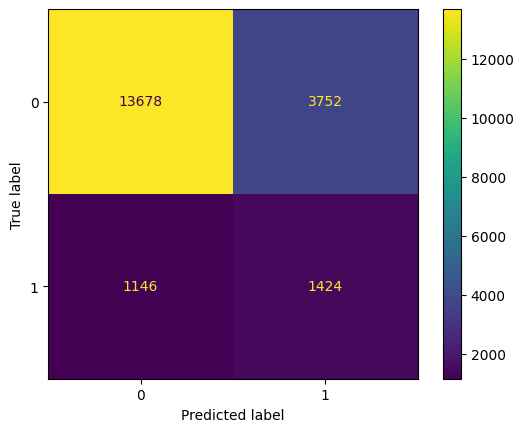

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for batch in test_loader:
    x, y = batch
    with torch.no_grad():
        y_hat = model(x.float())
        y_pred.extend((y_hat.squeeze() > 0.2).cpu().numpy().astype(int).tolist())
        y_true.extend(y.cpu().numpy().astype(int).tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(y_true.count(1))
print(y_true.count(0))

2570
17430


#### Plot ROC Curve of the model

The ROC curve and the AUC score shows a clearer picture of the accuracy of the model.

Baseline conclusion: The data without the graph nature of it is hard to learn and predict, especially because of the node feature data is very sparse and high dimensional.

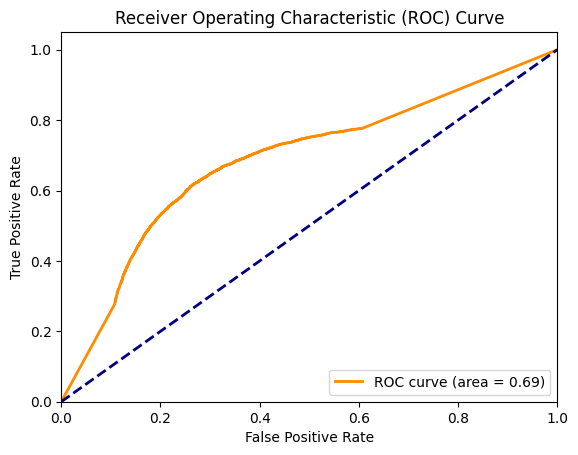

auroc: 0.6863676440057059


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        outputs = model(x.float()).squeeze()
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print(f'auroc: {roc_auc}')

# Baseline for Facebook

In [15]:
train_pairs_fb, test_pairs_fb = train_test_split(sampled_node_pairs_fb, test_size=0.2, random_state=42)
train_pairs_fb, val_pairs_fb = train_test_split(train_pairs_fb, test_size=0.15, random_state=42)

train_x_fb = train_pairs_fb.drop(columns=['connected'])
train_y_fb = train_pairs_fb['connected']
val_x_fb = val_pairs_fb.drop(columns=['connected'])
val_y_fb = val_pairs_fb['connected']
test_x_fb = test_pairs_fb.drop(columns=['connected'])
test_y_fb = test_pairs_fb['connected']

In [16]:
from torch.utils.data import TensorDataset, DataLoader

train_x_tensor = torch.tensor(train_x_fb.values)
train_y_tensor = torch.tensor(train_y_fb.values).squeeze()
val_x_tensor = torch.tensor(val_x_fb.values)
val_y_tensor = torch.tensor(val_y_fb.values).squeeze()
test_x_tensor = torch.tensor(test_x_fb.values)
test_y_tensor = torch.tensor(test_y_fb.values).squeeze()

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=128,pin_memory=True, shuffle=True, num_workers=7)
val_loader = DataLoader(val_dataset, batch_size=128,pin_memory=True, num_workers=7)
test_loader = DataLoader(test_dataset, batch_size=128,pin_memory=True, num_workers=7)

In [17]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'dim_1': {
            'values': [50, 100, 200]
        },
        'dim_2': {
            'values': [50, 100, 200]
        },
        'dim_3': {
            'values': [50, 100, 200]
        },
        'dim_4': {
            'values': [50, 100, 200]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        }
    }
}

In [26]:
sweep_id = wandb.sweep(sweep_config, project="base_coNNect_fb")

Create sweep with ID: uo4tu0d4
Sweep URL: https://wandb.ai/horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg/base_coNNect_fb/sweeps/uo4tu0d4


In [28]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb_logger = WandbLogger(project = 'base_coNNect_fb',log_model="all")
        input_size = train_x_fb.shape[1]
        model = BaselineNN(input_size, config.dim_1, config.dim_2, config.dim_3, config.dim_4, config.dropout)
        model = model.to('cuda')

        checkpoint_callback = pl.callbacks.ModelCheckpoint()
        early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_acc", patience=3, verbose=False, mode="max")


        trainer = pl.Trainer(max_epochs=20,
                    callbacks=[checkpoint_callback, early_stop_callback],
                    logger = wandb_logger,
                    log_every_n_steps=10,
                    accelerator="gpu",
                    devices=1,
                    )
        trainer.fit(model,train_loader,val_loader)
        wandb.finish()

In [29]:
wandb.agent(sweep_id, train_model, count=8)

wandb: Agent Starting Run: sqpf6v2r with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 50
wandb: 	dim_3: 100
wandb: 	dim_4: 50
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 281 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
train_acc,▆█▆▅▅██▅██▁█▁█▇▇▆▆▇▇▆▇▇▆▆█▇█▇▇▂▆▆▅▇▇█▆▇▅
train_loss,▃▆▄▅▄▂▃▂▁▃▃▇█▁▃▂▂▂▂▃▃▁▃▃▃▁▇▃▃▆▃▂▂▂▂▃▅▃▄▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇███
val_acc,▁▁▁▁
val_loss,▁▆▆█
epoch,3
train_acc,1
train_loss,0.00784
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: 4devwq96 with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 100
wandb: 	dim_3: 50
wandb: 	dim_4: 50
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 281 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 10.1 K | train
7  | layer_3   | Linear         | 5.0 K  | train
8  | layer_4   | Linear         | 2.6 K  | train
9  | layer_out | Linear         | 51     | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
train_acc,█▇▂▄▇█▇█▅▇▇▇▇▇██▇▄▅▇▇▇▇▇▂▁▇▄▂█▅▅█▇██▇▇▅▅
train_loss,▂▃▂▂▁▄▄▃▄▄▄▂▁▃▂▁▁▇▄▁▁▁▃▁▄▅▂▁▅█▃▃▃▅▄▁▁▂▁▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
val_acc,▁▁▁▁
val_loss,▄▄▁█
epoch,3
train_acc,0.98438
train_loss,0.06987
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: hzotu4s2 with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 50
wandb: 	dim_3: 200
wandb: 	dim_4: 200
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 140 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 2.6 K  | train
7  | layer_3   | Linear         | 10.2 K | train
8  | layer_4   | Linear         | 40.2 K | train
9  | layer_out | Linear         | 201    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
train_acc,▆▃▃▆██▆▃▁█▆▃▆▆▃▆▃█▃█▃▆▃▆▃█▆▆▆▃▆▆██▆▃▃▆▁▁
train_loss,▅▃▄▂▆▄▆▅▁▃▁▃▄▃▄▄▁▆▄▁▁▂▃▁▁▁▃█▃▂▃▁▃▄█▅▁▂▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▁▁▁
val_loss,▁▁█▂
epoch,3
train_acc,0.96094
train_loss,0.15937
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: 4d02wndg with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 50
wandb: 	dim_3: 100
wandb: 	dim_4: 200
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 281 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 5.0 K  | train
7  | layer_3   | Linear         | 5.1 K  | train
8  | layer_4   | Linear         | 20.2 K | train
9  | layer_out | Linear         | 201    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████
train_acc,▅▃▆▆▆▅▆▆▅▆▅▃▆██▆▃███▆▆█▅▆█▆▃██▁█▃▅▅▆▅▅▆█
train_loss,█▃▃▂▁▁▂▂▁▂▂▂▂▃▃▂▃▁▂▂▂▂▂▁▁▂▂▃▁▃▃▃▃▁▃▂▂▁▁▃
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
val_acc,▁▁▁▁
val_loss,█▁▃▇
epoch,3
train_acc,0.97656
train_loss,0.0943
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: wqtutcnb with config:
wandb: 	dim_1: 200
wandb: 	dim_2: 100
wandb: 	dim_3: 100
wandb: 	dim_4: 50
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 563 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 20.1 K | train
7  | layer_3   | Linear         | 10.1 K | train
8  | layer_4   | Linear         | 5.0 K  | train
9  | layer_out | Linear         | 51     | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆████████
train_acc,██▅▇▅█▄▇▅██▁█▇██▅█▇▄▄█▇▁▅▅▅▇██▇██▇▅▇▇█▅█
train_loss,▅▆▇▅▅▆▇▃▂▂▅▁▄▇▆█▅▁▇▄▂▁▁▃▄▄▃▆▁▁▁▄▃▅▅▅▅▇▁▇
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
val_acc,▁▁▁▁
val_loss,█▇▁▆
epoch,3
train_acc,0.97656
train_loss,0.08903
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: gio0e6br with config:
wandb: 	dim_1: 200
wandb: 	dim_2: 50
wandb: 	dim_3: 200
wandb: 	dim_4: 200
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 563 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 10.1 K | train
7  | layer_3   | Linear         | 10.2 K | train
8  | layer_4   | Linear         | 40.2 K | train
9  | layer_out | Linear         | 201    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆███████
train_acc,▅▆▅▆█▅▆▅▅███▆█▆▆█▆▅▆▆▆▅█▅█▅▆▆▅▅▆▁▃▃▅▅▅█▅
train_loss,▃▃▃▅█▃█▂▂▆▃▃▃▃▅▄▂▃▃▃▂▄▄▂▂▂▄▅▁▅▁▁▃▃▁▃▄▄▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
val_acc,▁▁▁▁
val_loss,█▂▃▁
epoch,3
train_acc,0.98438
train_loss,0.07158
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: fa357x26 with config:
wandb: 	dim_1: 50
wandb: 	dim_2: 200
wandb: 	dim_3: 50
wandb: 	dim_4: 200
wandb: 	dropout: 0.3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 140 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 10.2 K | train
7  | layer_3   | Linear         | 10.1 K | train
8  | layer_4   | Linear         | 10.2 K | train
9  | layer_out | Linear         | 201    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████████
train_acc,▇▆▇▂█▅▇▇█▇▅▇▇█▅█▇▆█▇█▃▇▇█▁▆▆█▅▇█▇▆▅▅▇▇█▇
train_loss,▃▅█▂▃█▁▆▁▃▁▃▃▁▃▁▂▄▄▃▂▁▁▁▃▂▅▄▁▂▇▄▃▅▁▃▄▆▁▁
trainer/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
val_acc,▁▁▁▁
val_loss,▅▄▁█
epoch,3
train_acc,0.98438
train_loss,0.06396
trainer/global_step,6375
val_acc,0.98947


wandb: Agent Starting Run: n4jy2vyz with config:
wandb: 	dim_1: 100
wandb: 	dim_2: 200
wandb: 	dim_3: 200
wandb: 	dim_4: 200
wandb: 	dropout: 0.4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 281 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 20.2 K | train
7  | layer_3   | Linear         | 40.2 K | train
8  | layer_4   | Linear         | 40.2 K | train
9  | layer_out | Linear         | 201    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆████████████
train_acc,▅█▇▇█▇█▇██▂██▇▇▇▂█▇▄▅▄▄▄▅▁▇▇▇▇▅▅▄▂▇▇█▇█▂
train_loss,▃▅▃▂▃▃▁█▅▅▂▂▅▃▅▃▂▄▂▁▂▁▂▃▂▅▁▃▁▁▂▁▁▃▄▃▃▁▃▆
trainer/global_step,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
val_acc,▁▁▁▁
val_loss,▇█▄▁
epoch,3
train_acc,0.96875
train_loss,0.14901
trainer/global_step,6375
val_acc,0.98947


In [30]:
api = wandb.Api()
sweep = api.sweep(f"horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg/base_coNNect_fb/sweeps/uo4tu0d4")

# Get best run parameters
best_run = sweep.best_run(order='validation/accuracy')
best_parameters = best_run.config
print(best_parameters)

wandb: Sorting runs by -summary_metrics.validation/accuracy


{'dim_1': 100, 'dim_2': 50, 'dim_3': 100, 'dim_4': 200, 'dropout': 0.4}


In [31]:
input_size = train_x_fb.shape[1]
model = BaselineNN(input_size, 100, 50, 100, 200, 0.4)
model = model.to('cuda')

In [32]:
checkpoint_callback = pl.callbacks.ModelCheckpoint()
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_acc", patience=3, verbose=False, mode="max")
trainer = pl.Trainer(max_epochs=10,
                    callbacks=[checkpoint_callback, early_stop_callback],
                    log_every_n_steps=10,
                    accelerator="gpu",
                    devices=1,
                    )

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type           | Params | Mode 
------------------------------------------------------
0  | layer_1   | Linear         | 281 K  | train
1  | relu      | ReLU           | 0      | train
2  | dropout_1 | Dropout        | 0      | train
3  | dropout_2 | Dropout        | 0      | train
4  | dropout_3 | Dropout        | 0      | train
5  | dropout_4 | Dropout        | 0      | train
6  | layer_2   | Linear         | 5.0 K  | train
7  | layer_3   | Linear         | 5.1 K  | train
8  | layer_4   | Linear         | 20.2 K | train
9  | layer_out | Linear         | 201    | train
10 | sigmoid   | Sigmoid      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [33]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9895666837692261     │
│         test_loss         │    0.04919974505901337    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04919974505901337, 'test_acc': 0.9895666837692261}]

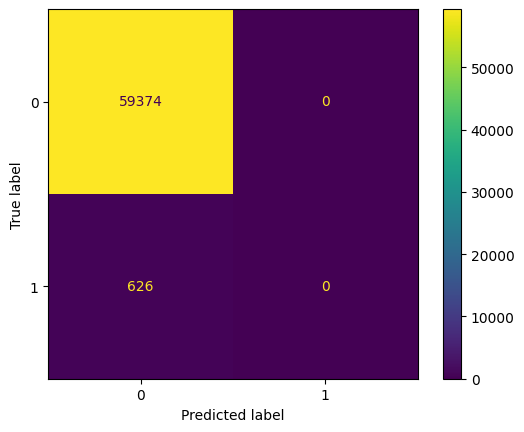

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for batch in test_loader:
    x, y = batch
    with torch.no_grad():
        y_hat = model(x.float())
        y_pred.extend((y_hat.squeeze() > 0.2).cpu().numpy().astype(int).tolist())
        y_true.extend(y.cpu().numpy().astype(int).tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

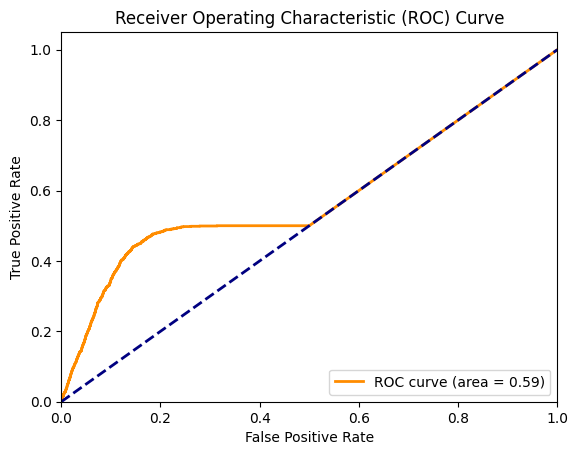

auroc: 0.5862504655871252


In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        outputs = model(x.float()).squeeze()
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print(f'auroc: {roc_auc}')